## Machine Learning

### Importação de bibliotecas

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from joblib import dump

from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

### Ridge

In [4]:
# Variáveis categóricas
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"] # Coluna categórica que não está ordenada

coluna_ordinal_encoder = ["median_income_cat"] # Coluna categorica que já está ordenada

In [5]:
# Variáveis numéricas
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder) # Colunas com outliers

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()), # Transformador menos sensíveis a outiliers
    ("poly", PolynomialFeatures(degree=1, include_bias=False)), # Polinômio de grau 1
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder), # Coluna categorica que já está ordenada
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder), # Coluna categórica que não está ordenada
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler), # Transformador menos sensíveis a outiliers e com polinômio
    ],
)

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [8]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [9]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


### Melhor parâmetro

In [10]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3], # Busca melhor grau de polinômio
    "regressor__reg__alpha": [0.01, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0], # Busca melhor alpha
}

In [11]:
# Avaliando o modelo de regressão linear
grid_search = grid_search_cv_regressor(
    regressor=Ridge(), 
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"), # Melhor transformador de target
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
# Ajustando o modelo
grid_search.fit(X, y)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


c:\Users\lsgal\miniconda3\envs\machine_learning\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 10.0}

Alpha com valor de 10, se estabilizando o modelo

In [14]:
grid_search.best_score_

np.float64(-50446.767334453514)

Comparado ao modelo de LinearRegression Polinomial e ElasticNet, teve um score maior, sendo melhor usar o modelo Ridge, a principio

In [ ]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude,-1.030282
robust_scaler_poly__latitude,-0.964740
one_hot__ocean_proximity_INLAND,-0.468576
robust_scaler_poly__latitude longitude population_per_household,-0.420654
robust_scaler_poly__population_per_household,-0.332301
...,...
robust_scaler_poly__housing_median_age median_income,0.247875
robust_scaler_poly__latitude median_income population_per_household,0.249482
robust_scaler_poly__latitude^2 longitude,0.250627
robust_scaler_poly__bedrooms_per_room,0.337916


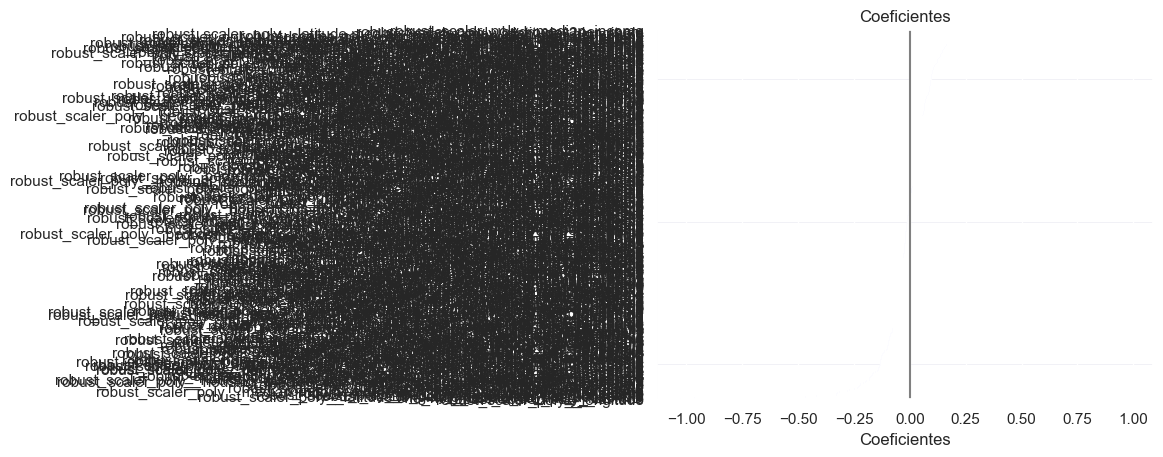

In [16]:
plot_coeficientes(coefs)

In [17]:
coefs[coefs["coeficiente"] == 0]

,coeficiente


Ridge não tende zerar os coeficientes

In [18]:
# Coeficientes com valores entre -0.2 e 0.2, diferentes de 0
coefs[coefs["coeficiente"].between(-0.2, 0.2) & (coefs["coeficiente"] != 0)]

,coeficiente
one_hot__ocean_proximity_NEAR BAY,-0.198509
robust_scaler_poly__housing_median_age population_per_household total_bedrooms,-0.195927
robust_scaler_poly__households median_income^2,-0.182130
robust_scaler_poly__housing_median_age median_income population_per_household,-0.180901
robust_scaler_poly__longitude median_income,-0.180810
...,...
robust_scaler_poly__total_bedrooms,0.169155
robust_scaler_poly__median_income population population_per_household,0.174807
robust_scaler_poly__bedrooms_per_room rooms_per_household total_bedrooms,0.175080
robust_scaler_poly__median_income population rooms_per_household,0.175765


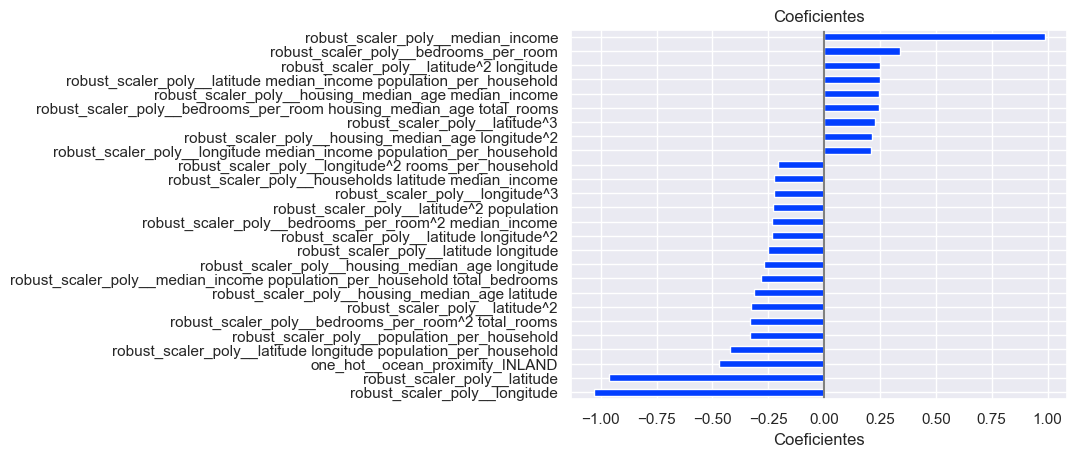

In [19]:
# Coeficientes que não estão entre -0.1, 0.1
plot_coeficientes(coefs[~coefs["coeficiente"].between(-0.2, 0.2)])

Renda (median_income) retornou como maior coeficiente, tendo maior peso pra explicar o modelo. Além das features de idade da casa com renda e quartos por cômodos. E latitude e longitude, contribuindo pouco para o target.

In [20]:
regressors = {
    # DummyRegressor
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    # LinearRegression sem target transformado
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    # LinearRegression com target transformado
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    # Melhor modelo
    "Ridge_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

In [21]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.005907,0.004989,-0.000081,-77516.042766,-96239.705692,0.010895
1,DummyRegressor,0.003587,0.003994,-0.000146,-75787.787194,-95217.629397,0.00758
2,DummyRegressor,0.004007,0.00608,-0.001737,-76753.598961,-96253.253947,0.010087
3,DummyRegressor,0.002994,0.003849,-0.000101,-76837.804811,-95983.885799,0.006843
4,DummyRegressor,0.003383,0.008522,-0.000114,-76617.245449,-96182.764729,0.011905
5,LinearRegression,0.033894,0.014501,0.682162,-39855.690996,-54254.958188,0.048394
6,LinearRegression,0.032945,0.012567,0.66999,-40272.565467,-54695.230283,0.045512
7,LinearRegression,0.035149,0.012504,0.649247,-42178.05929,-56955.988706,0.047653
8,LinearRegression,0.03676,0.013373,0.669873,-40806.492497,-55146.318803,0.050133
9,LinearRegression,0.036607,0.014062,0.669023,-40788.496497,-55331.35106,0.050668


In [22]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.003975,0.005487,-0.000436,-76702.495836,-95975.447913,0.009462
LinearRegression,0.035071,0.013401,0.668059,-40780.26095,-55276.769408,0.048472
LinearRegression_target,0.047058,0.014253,0.678041,-38680.373645,-54434.972842,0.06131
Ridge_grid_search,0.216772,0.034228,0.723296,-35346.219616,-50456.543286,0.251


In [23]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.003975,0.005487,-0.000436,-76702.495836,-95975.447913,0.009462
LinearRegression,0.035071,0.013401,0.668059,-40780.26095,-55276.769408,0.048472
LinearRegression_target,0.047058,0.014253,0.678041,-38680.373645,-54434.972842,0.06131
Ridge_grid_search,0.216772,0.034228,0.723296,-35346.219616,-50456.543286,0.251


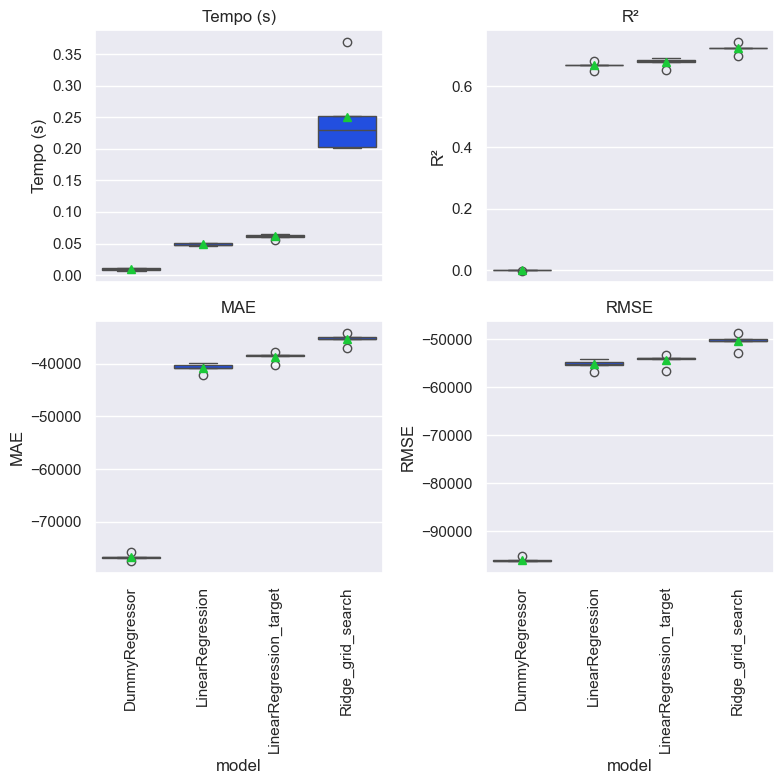

In [24]:
plot_comparar_metricas_modelos(df_resultados)

- Tempo: grid search (ridge) está levando um tempo maior em relação ao LinearRegression. E a Ridge é mais rápida de processamento que a Feature Polinomial e ElasticNet
- R2, MAE, RMSE: grid search (ridge) melhora um pouco as métricas que o LinearRegression, Feature Polinomial e ElasticNet
- É melhor usar o grid search (ridge) que o LinearRegression, Feature Polinomial e ElasticNet

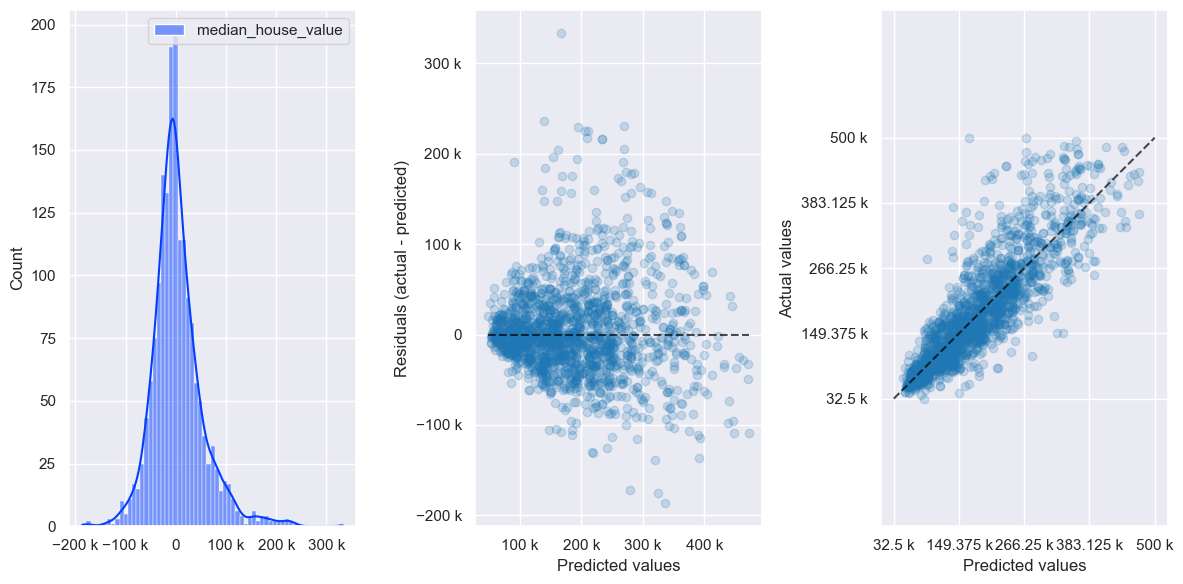

In [25]:
# Plota gráfico de resíduos com melhor modelo, usando 10% dos dados e com formatação de abreviação dos números
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

Pegando 10% dos dados e comparando os dados reais com os dados do melhor estimador de modelo (Ridge):
- Percebe-se que uma parte significativa dos pontos estão próximos da reta no gráfico de resíduos (2), fazendo que o modelo tenha menos erros
- Possue mais erros positivos que negativos, sendo observado tanto pelo histograma (1) com a cauda mais alongada para os valores positivos e o gráfico de dispersão de resíduos (2) com mais valores acima da reta que abaixo da reta

### Salvando o modelo

https://scikit-learn.org/stable/model_persistence.html

In [26]:
dump(grid_search.best_estimator_, MODELO_FINAL)

['D:\\Usuários\\LSG\\Cursos\\Data Science\\Hashtag\\Aulas\\13. Regressão com Modelos Lineares\\5. Projeto de Regressão\\modelos\\ridge_polyfeat_target_quantile.joblib']